# Testing the MotionSense dataset on different Window sizes

The performance of the drift algorithm for the simualted datasets under different window sizes is checked

In [8]:
import pandas as pd
import numpy as np
from sklearn import datasets
from evidently.report import Report
from evidently.metrics import DataDriftTable
from evidently.metrics import DatasetDriftMetric

from sklearn.datasets import fetch_openml
from typing import Tuple
import pandas as pd
import numpy as np 
from scipy import stats
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import entropy

from evidently.calculations.stattests import jensenshannon_stat_test
from evidently.calculations.stattests import kl_div_stat_test
from evidently.calculations.stattests import ks_stat_test
from evidently.calculations.stattests import psi_stat_test
from evidently.calculations.stattests import wasserstein_stat_test
from sklearn.metrics import confusion_matrix

from scipy.stats import expon
RED = '#ed0400'
GREY = '#4d4d4d'
PALETTE=['#0a5f38', '#6c3461', '#ab1239']

In [9]:
def plot_example(ref: pd.Series, curr: pd.Series):
  fig = plt.figure(constrained_layout=True, figsize=(15,7))

  gs = GridSpec(2, 3, figure=fig)
  ax1 = fig.add_subplot(gs[0, :])
  ax2 = fig.add_subplot(gs[1, 0])
  ax3 = fig.add_subplot(gs[1, 1])
  ax4 = fig.add_subplot(gs[1, 2])

  # plot feature in time
  ref_points = int(np.round(150 * len(ref) /(len(ref) + len(curr))))
  curr_points = 150 - ref_points

  ref_in_time = [np.mean(x) for x in np.array_split(ref, ref_points)]
  curr_in_time = [np.mean(x) for x in np.array_split(curr, curr_points)]

  ax1.plot(range(ref_points), ref_in_time, color=GREY)
  ax1.plot(range(ref_points, ref_points + curr_points), curr_in_time, color=RED)

  # plot referense distr
  sns.histplot(ref, color=GREY, ax=ax2)
  # plot current distr
  sns.histplot(curr, color=RED, ax=ax3)
  # plot two distr
  sns.histplot(ref, color=GREY, ax=ax4)
  sns.histplot(curr, color=RED, ax=ax4)
  plt.show()

def evaluate_drift(ref: pd.Series, curr: pd.Series):
  report = pd.DataFrame(columns=['stat_test', 'drift_score', 'is_drifted'])
  for i, (stattest, threshold) in enumerate(
      zip(
          [ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test],
          [0.05, 0.1, 0.1, 0.1, 0.1]
      )
  ):
    report.loc[i, 'stat_test'] = stattest.display_name
    report.loc[i, 'drift_score'], report.loc[i, 'is_drifted'] = stattest.func(ref, curr, 'num', threshold)
  return report

def return_drift(ref: pd.Series, curr: pd.Series):
  report = pd.DataFrame(columns=['stat_test', 'drift_score', 'is_drifted'])
  for i, (stattest, threshold) in enumerate(
      zip(
          [ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test],
          [0.05, 0.1, 0.1, 0.1, 0.1]
      )
  ):
    report.loc[i, 'stat_test'] = stattest.display_name
    report.loc[i, 'drift_score'], report.loc[i, 'is_drifted'] = stattest.func(ref, curr, 'num', threshold)
  return report['drift_score']


In [10]:
def add_drift(curr_new: pd.Series, drift_size: float, drift_ratio: float, drift_mode: str='fixed') -> pd.Series:
  """Artificially adds a shift to the data.
  Args:
    curr: initial data
    drift_size: percents initial values would be increased by
    drift_ratio: defines what percent of data would be drifted
    drift_mode:
      if drift_mode == 'fixed': 
        # here we should use mean(reference), but in out experiment mean(reference) = mean(current) at this stage
        all values moved by fixed delta = (alpha + mean(feature)) * drift_size
      elif: 
        drift_mode == 'relative': vlues moved by delta(value) = value * drift_size
  Returns:
    curr: drifted data
  """
  curr = curr_new.copy()
  alpha = 0.001
  i = int(np.round(len(curr) * drift_ratio))
  if drift_mode == 'fixed':
    delta = (alpha + np.mean(curr)) * drift_size
    curr[:i] = curr[:i] + delta
  elif drift_mode=='random':
    drift_curr = (np.random.normal(1,1,i))*drift_size*np.mean(curr)
    curr[:i] = curr[:i] + drift_curr
  elif drift_mode=='random_2':
    #apply_not = np.random.randint(low=0,high=2,size=i)
    drift_curr = (np.random.normal(0,1,i))*drift_size*np.std(curr)
    #drift_curr = np.multiply(apply_not,drift_curr)
    #print(drift_curr)
    curr[:i] = curr[:i] + drift_curr
  else:
    curr[:i] = curr[:i]*(1 + drift_size)
  return curr

In [11]:
def add_new_drift(curr_new: pd.Series, drift_size: float, start_index: int,stop_index:int,drift_mode :str= "0-shift"):
    
    drift_interval = (stop_index - start_index) 
    curr = curr_new.copy()
    if(drift_mode=="0-shift"):
        drift_curr = (np.random.normal(0,1,drift_interval))*drift_size*np.std(curr)
    else:
        drift_curr = (np.random.normal(1,1,drift_interval))*drift_size*np.std(curr)
    
    #print(len(drift_curr))
    #print(len(curr[start_index:stop_index]))
    
    
    curr[start_index:stop_index] = curr[start_index:stop_index] + drift_curr
    
    return curr

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Testing

## a) Sudden drift between subject 1 and 2

We consider sudden drift in data. The reference is set as the motion data of subject 1 under different activities and the drift is considered as a combination of subject 1 and subject 10 data. In the test data, data of Subject 10 is used after the first 25000 data points.

In [56]:

### Creating the reference and drift datasets
folder_location = '/Users/kiranjyothisheena/Documents/Kiran_Files/CDL_Practicum/Datasets/Motion_Sense/Test_datasets/'

subject_1 = pd.read_csv(folder_location + 'Subject_1_random.csv')
subject_10 = pd.read_csv(folder_location + 'Subject_10_random.csv')


ref_total = subject_1
curr_test = subject_10

## Considering the first column to test drift
curr_test  = curr_test.iloc[:,0] ## Test data
ref_total  = ref_total.iloc[:,0] ## Reference data to detect drift
curr_test = curr_test[:100000]
ref_total = ref_total[:100000]


curr_test = pd.concat([ref_total[:25000],curr_test]) ## Making the first 25000 points as ref data
curr_test = curr_test.reset_index(drop=True)

curr_indi = pd.Series(np.concatenate([np.zeros(25000),np.ones(len(curr_test)-25000)]))

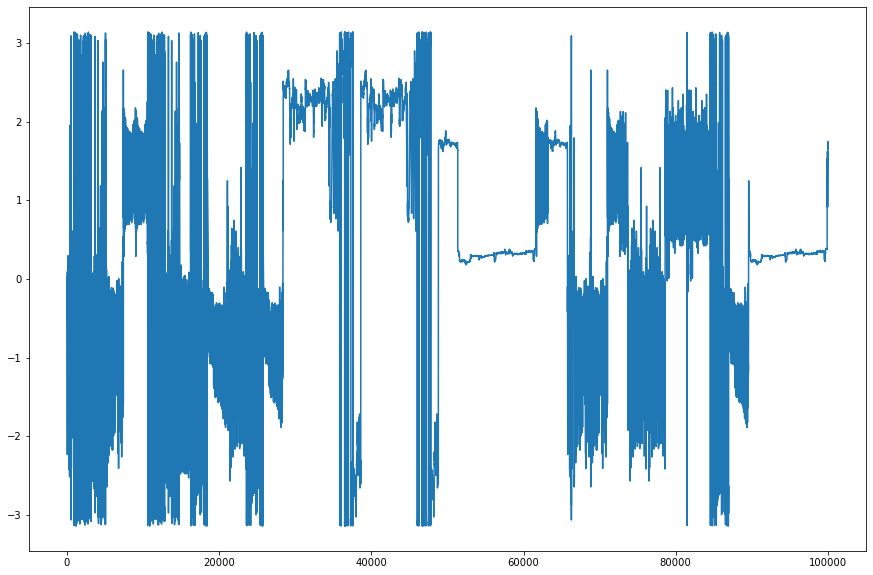

In [57]:
## Plotting the reference

fig,ax = plt.subplots(figsize=(15,10))
plt.plot(ref_total)

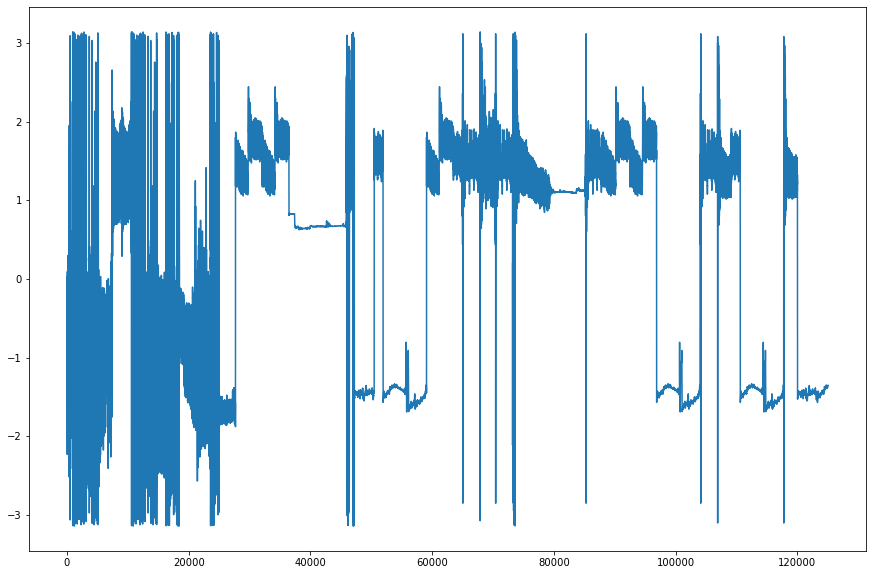

In [58]:
## Plotting the test data

fig,ax = plt.subplots(figsize=(15,10))
plt.plot(curr_test)

In [59]:
def plot_drift_graph(df_plot,sheet_name):
    plt.plot(df_plot['K-S p_value'],label='K-S p_value')
    plt.plot(df_plot['PSI'],label='PSI')
    plt.plot(df_plot['Kullback-Leibler divergence'],label='Kullback-Leibler divergence')
    plt.plot(df_plot['Jensen-Shannon distance'],label='Jensen-Shannon distance')
    plt.plot(df_plot['Wasserstein distance (normed)'],label='Wasserstein distance (normed)')
    plt.xticks(df_plot.index[::100],df_plot['index'][::100],rotation=90)
    plt.yticks(range(15),range(15))
    #plt.axvline(x = list(df_plot[df_plot['index']=='t=10000'].index)[0], color = 'black', label = 'Drift',ls='--')
    plt.xlabel('Time',fontsize=15)
    plt.ylabel('Parameter Value',fontsize=15)
    plt.title(sheet_name,fontsize=15)
    plt.grid()
    plt.legend()

In [62]:
#Driver code to test for drift

curr_test_file = "Subject_1_10_sudden_drift"

N_list = [100]
axes_ind = 1


curr_ref = pd.Series(np.random.choice(ref_total,20000)) ## Representative sample of reference distribution

for N in N_list:
    
    print('Current Window size is ',N)
    
    curr_buff = curr_test[:N]
    chunk_size= 10

    curr_start = N
    curr_end = N+chunk_size

    end_data = 100000
    curr_t = N

    result_pd = pd.DataFrame()
    fun_name = [ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test]
    test_names = [each_test.display_name for each_test in fun_name]
    result_pd['Test'] = test_names

    #curr_ref = ref_total[:N]
    #curr_ref = ref_total[:]


    while(curr_end <= end_data ):
        
        curr_res = return_drift(curr_ref, curr_buff)
        result_pd['t=' + str(curr_t)] = curr_res

        ## Importing the new chunk
        curr_start = curr_start + chunk_size
        curr_end = curr_end + chunk_size
        curr_chunk = curr_test[curr_start:curr_end]

        curr_buff = curr_buff[chunk_size:]
        curr_buff = pd.concat([curr_buff,curr_chunk])
        curr_t = curr_t + chunk_size

    result_pd = result_pd.T

    
    result_pd.to_csv('/Users/kiranjyothisheena/Documents/Kiran_Files/CDL_Practicum/Results/Motion_Sense_Exp/' + "N=" + str(N) + "_" + curr_test_file + ".csv")

Current Window size is  100


## Results

In [61]:
fun_name = [ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test]
test_names = [each_test.display_name for each_test in fun_name]

res_path = '/Users/kiranjyothisheena/Documents/Kiran_Files/CDL_Practicum/Results/Motion_Sense_Exp/'


### N = 20000

Total drift points is  750.0


,Test,TN,FP,FN,TP,Accuracy,Precision,Recall
0,PSI,50,0,187,563,0.76625,1.0,0.750667
0,JS,50,0,177,573,0.77875,1.0,0.764000
0,KL_div,50,0,189,561,0.76375,1.0,0.748000


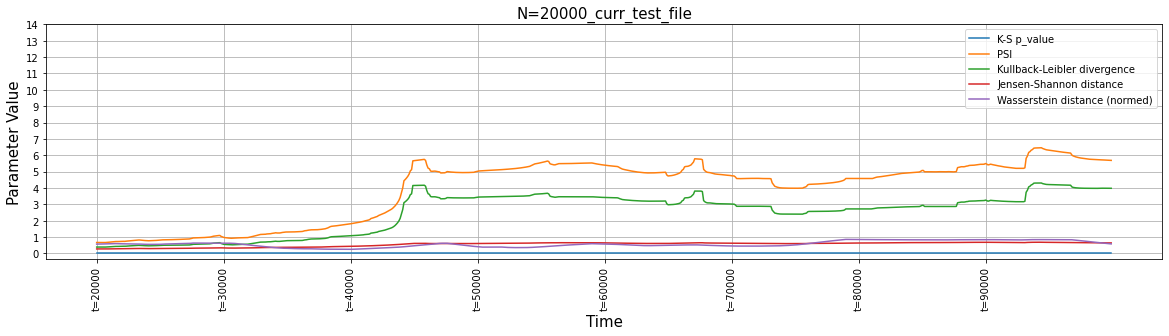

In [64]:
#### OVERALL (N=4000)

test_file_name = 'N=20000_Subject_1_10_sudden_drift.csv'
result_pd = pd.read_csv(res_path + test_file_name)

N= 20000
chunk_size=100
end_data = 100000

result_pd.columns = result_pd.iloc[0]
result_pd.drop(result_pd.index[0],inplace=True)
result_pd.reset_index(drop=True,inplace=True)
result_pd.rename({"Test":"index"},inplace=True,axis=1)

#fig,ax = plt.subplots(figsize=(20,25))
#plt.subplot(4,1,axes_ind)
#plot_drift_graph(result_pd,"Drift fig")

## Creating a dataframe to plot the results
result_plot = result_pd.copy()
result_plot[['K-S p_value', 'PSI', 'Kullback-Leibler divergence',
       'Jensen-Shannon distance', 'Wasserstein distance (normed)']] = result_plot[['K-S p_value', 'PSI', 'Kullback-Leibler divergence',
       'Jensen-Shannon distance', 'Wasserstein distance (normed)']].astype('float64')
#result_check
fig,ax = plt.subplots(figsize=(20,25))
plt.subplot(5,1,axes_ind)
plot_drift_graph(result_plot,"N=" + str(N) + "_" + 'curr_test_file')

result_pd_2  = result_pd.copy()
for each_test in test_names:
    result_pd_2[each_test] = result_pd_2[each_test].astype('float')

index_col = np.arange(start=N,stop=end_data,step=chunk_size)

indi_column = curr_indi[index_col].reset_index(drop=True)

result_pd_2['Correct_mark'] = indi_column

print('Total drift points is ',sum(indi_column))

PSI_threshold = 3
JS_threshhold = 0.5
KL_Div_threshold = 2

result_pd_2['PSI_drift'] = np.where(result_pd_2['PSI']>PSI_threshold,1,0)
result_pd_2['JS_drift'] = np.where(result_pd_2['Jensen-Shannon distance']>JS_threshhold,1,0)
result_pd_2['KL_drift'] = np.where(result_pd_2['Kullback-Leibler divergence']>KL_Div_threshold,1,0)

tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['PSI_drift'],labels=[0,1]).ravel()
summary_pd = pd.DataFrame({"Test":["PSI"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['JS_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["JS"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['KL_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["KL_div"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])

summary_pd['Accuracy'] = (summary_pd['TP'] + summary_pd['TN'])/summary_pd.sum(axis=1,numeric_only=True)
summary_pd['Precision'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FP'])
summary_pd['Recall'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FN'])

summary_pd

### N = 16000

In [79]:


test_file_name = 'N=16000_Subject_1_10_sudden_drift.csv'
result_pd = pd.read_csv(res_path + test_file_name)

N= 16000
chunk_size=100
end_data = 100000

result_pd.columns = result_pd.iloc[0]
result_pd.drop(result_pd.index[0],inplace=True)
result_pd.reset_index(drop=True,inplace=True)
result_pd.rename({"Test":"index"},inplace=True,axis=1)

#fig,ax = plt.subplots(figsize=(20,25))
#plt.subplot(4,1,axes_ind)
#plot_drift_graph(result_pd,"Drift fig")

result_pd_2  = result_pd.copy()
for each_test in test_names:
    result_pd_2[each_test] = result_pd_2[each_test].astype('float')

index_col = np.arange(start=N,stop=end_data,step=chunk_size)

indi_column = curr_indi[index_col].reset_index(drop=True)

result_pd_2['Correct_mark'] = indi_column

print('Total drift points is ',sum(indi_column))

PSI_threshold = 3
JS_threshhold = 0.5
KL_Div_threshold = 2

result_pd_2['PSI_drift'] = np.where(result_pd_2['PSI']>PSI_threshold,1,0)
result_pd_2['JS_drift'] = np.where(result_pd_2['Jensen-Shannon distance']>JS_threshhold,1,0)
result_pd_2['KL_drift'] = np.where(result_pd_2['Kullback-Leibler divergence']>KL_Div_threshold,1,0)

tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['PSI_drift'],labels=[0,1]).ravel()
summary_pd = pd.DataFrame({"Test":["PSI"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['JS_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["JS"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['KL_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["KL_div"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])

summary_pd['Accuracy'] = (summary_pd['TP'] + summary_pd['TN'])/summary_pd.sum(axis=1,numeric_only=True)
summary_pd['Precision'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FP'])
summary_pd['Recall'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FN'])

summary_pd

Total drift points is  750.0


,Test,TN,FP,FN,TP,Accuracy,Precision,Recall
0,PSI,90,0,149,601,0.822619,1.0,0.801333
0,JS,90,0,144,606,0.828571,1.0,0.808000
0,KL_div,90,0,150,600,0.821429,1.0,0.800000


### N = 10000

In [78]:

test_file_name = 'N=10000_Subject_1_10_sudden_drift.csv'
result_pd = pd.read_csv(res_path + test_file_name)

N= 10000
chunk_size=100
end_data = 100000

result_pd.columns = result_pd.iloc[0]
result_pd.drop(result_pd.index[0],inplace=True)
result_pd.reset_index(drop=True,inplace=True)
result_pd.rename({"Test":"index"},inplace=True,axis=1)

#fig,ax = plt.subplots(figsize=(20,25))
#plt.subplot(4,1,axes_ind)
#plot_drift_graph(result_pd,"Drift fig")

result_pd_2  = result_pd.copy()
for each_test in test_names:
    result_pd_2[each_test] = result_pd_2[each_test].astype('float')

index_col = np.arange(start=N,stop=end_data,step=chunk_size)

indi_column = curr_indi[index_col].reset_index(drop=True)

result_pd_2['Correct_mark'] = indi_column

print('Total drift points is ',sum(indi_column))

PSI_threshold = 3
JS_threshhold = 0.5
KL_Div_threshold = 2


result_pd_2['PSI_drift'] = np.where(result_pd_2['PSI']>PSI_threshold,1,0)
result_pd_2['JS_drift'] = np.where(result_pd_2['Jensen-Shannon distance']>JS_threshhold,1,0)
result_pd_2['KL_drift'] = np.where(result_pd_2['Kullback-Leibler divergence']>KL_Div_threshold,1,0)

tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['PSI_drift'],labels=[0,1]).ravel()
summary_pd = pd.DataFrame({"Test":["PSI"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['JS_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["JS"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['KL_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["KL_div"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])

summary_pd['Accuracy'] = (summary_pd['TP'] + summary_pd['TN'])/summary_pd.sum(axis=1,numeric_only=True)
summary_pd['Precision'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FP'])
summary_pd['Recall'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FN'])

summary_pd

Total drift points is  750.0


,Test,TN,FP,FN,TP,Accuracy,Precision,Recall
0,PSI,150,0,91,659,0.898889,1.0,0.878667
0,JS,150,0,86,664,0.904444,1.0,0.885333
0,KL_div,150,0,94,656,0.895556,1.0,0.874667


### N = 8000

In [80]:

test_file_name = 'N=8000_Subject_1_10_sudden_drift.csv'
result_pd = pd.read_csv(res_path + test_file_name)

N= 8000
chunk_size=100
end_data = 100000

result_pd.columns = result_pd.iloc[0]
result_pd.drop(result_pd.index[0],inplace=True)
result_pd.reset_index(drop=True,inplace=True)
result_pd.rename({"Test":"index"},inplace=True,axis=1)

#fig,ax = plt.subplots(figsize=(20,25))
#plt.subplot(4,1,axes_ind)
#plot_drift_graph(result_pd,"Drift fig")

result_pd_2  = result_pd.copy()
for each_test in test_names:
    result_pd_2[each_test] = result_pd_2[each_test].astype('float')

index_col = np.arange(start=N,stop=end_data,step=chunk_size)

indi_column = curr_indi[index_col].reset_index(drop=True)

result_pd_2['Correct_mark'] = indi_column

print('Total drift points is ',sum(indi_column))

PSI_threshold = 3
JS_threshhold = 0.5
KL_Div_threshold = 2


result_pd_2['PSI_drift'] = np.where(result_pd_2['PSI']>PSI_threshold,1,0)
result_pd_2['JS_drift'] = np.where(result_pd_2['Jensen-Shannon distance']>JS_threshhold,1,0)
result_pd_2['KL_drift'] = np.where(result_pd_2['Kullback-Leibler divergence']>KL_Div_threshold,1,0)

tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['PSI_drift'],labels=[0,1]).ravel()
summary_pd = pd.DataFrame({"Test":["PSI"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['JS_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["JS"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['KL_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["KL_div"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])

summary_pd['Accuracy'] = (summary_pd['TP'] + summary_pd['TN'])/summary_pd.sum(axis=1,numeric_only=True)
summary_pd['Precision'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FP'])
summary_pd['Recall'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FN'])

summary_pd

Total drift points is  750.0


,Test,TN,FP,FN,TP,Accuracy,Precision,Recall
0,PSI,170,0,72,678,0.921739,1.0,0.904000
0,JS,170,0,69,681,0.925000,1.0,0.908000
0,KL_div,170,0,76,674,0.917391,1.0,0.898667


### N=4000

Total drift points is  750.0


,Test,TN,FP,FN,TP,Accuracy,Precision,Recall
0,PSI,199,11,23,727,0.964583,0.985095,0.969333
0,JS,198,12,19,731,0.967708,0.983849,0.974667
0,KL_div,199,11,33,717,0.954167,0.984890,0.956000


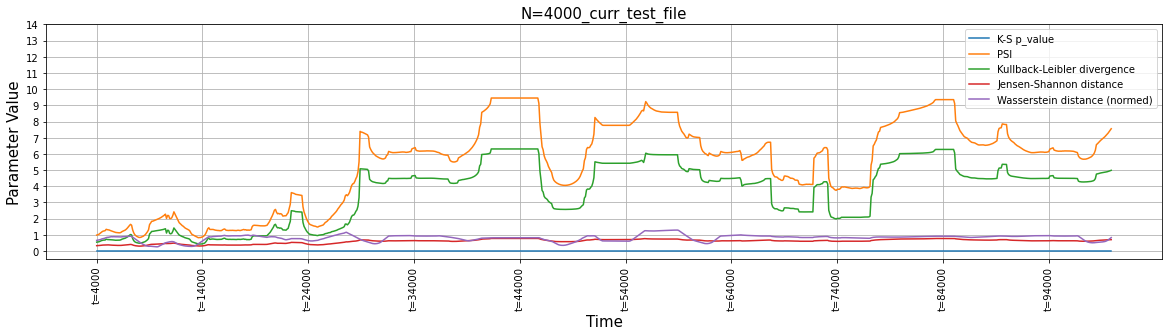

In [63]:
#### OVERALL (N=100000)

test_file_name = 'N=4000_Subject_1_10_sudden_drift.csv'
result_pd = pd.read_csv(res_path + test_file_name)

N= 4000
chunk_size=100
end_data = 100000

result_pd.columns = result_pd.iloc[0]
result_pd.drop(result_pd.index[0],inplace=True)
result_pd.reset_index(drop=True,inplace=True)
result_pd.rename({"Test":"index"},inplace=True,axis=1)

#fig,ax = plt.subplots(figsize=(20,25))
#plt.subplot(4,1,axes_ind)
#plot_drift_graph(result_pd,"Drift fig")

## Creating a dataframe to plot the results
result_plot = result_pd.copy()
result_plot[['K-S p_value', 'PSI', 'Kullback-Leibler divergence',
       'Jensen-Shannon distance', 'Wasserstein distance (normed)']] = result_plot[['K-S p_value', 'PSI', 'Kullback-Leibler divergence',
       'Jensen-Shannon distance', 'Wasserstein distance (normed)']].astype('float64')
#result_check
fig,ax = plt.subplots(figsize=(20,25))
plt.subplot(5,1,axes_ind)
plot_drift_graph(result_plot,"N=" + str(N) + "_" + 'curr_test_file')

result_pd_2  = result_pd.copy()
for each_test in test_names:
    result_pd_2[each_test] = result_pd_2[each_test].astype('float')

index_col = np.arange(start=N,stop=end_data,step=chunk_size)

indi_column = curr_indi[index_col].reset_index(drop=True)

result_pd_2['Correct_mark'] = indi_column

print('Total drift points is ',sum(indi_column))

PSI_threshold = 3
JS_threshhold = 0.5
KL_Div_threshold = 2


result_pd_2['PSI_drift'] = np.where(result_pd_2['PSI']>PSI_threshold,1,0)
result_pd_2['JS_drift'] = np.where(result_pd_2['Jensen-Shannon distance']>JS_threshhold,1,0)
result_pd_2['KL_drift'] = np.where(result_pd_2['Kullback-Leibler divergence']>KL_Div_threshold,1,0)

tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['PSI_drift'],labels=[0,1]).ravel()
summary_pd = pd.DataFrame({"Test":["PSI"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['JS_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["JS"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['KL_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["KL_div"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])

summary_pd['Accuracy'] = (summary_pd['TP'] + summary_pd['TN'])/summary_pd.sum(axis=1,numeric_only=True)
summary_pd['Precision'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FP'])
summary_pd['Recall'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FN'])

summary_pd

For this particular case, it is noticed that an intermediate window size of 4000 has the highest accuracy.

## b) Drift between Subject 1 and Subject 2 exponentially distributed

The reference series is the attitude.roll value of the dataset of subject 2. The test series is an artifically drifted dataset where we have added drift by adding the data points of subject 11 into the reference series.
The Interval between each drift window is exponential distributed with lambda = 2000 and size of each drift window is normally distributed with mean = 1000 and std = 50

In [18]:

### Creating the reference and drift datasets
folder_location = '/Users/kiranjyothisheena/Documents/Kiran_Files/CDL_Practicum/Datasets/Motion_Sense/Test_datasets/'


ref_total = pd.read_csv('/Users/kiranjyothisheena/Documents/Kiran_Files/CDL_Practicum/Datasets/Motion_Sense/A_DeviceMotion_data/jog_9/sub_2.csv')
ref_total.drop("Unnamed: 0",axis=1,inplace=True)


curr_test = pd.read_csv(folder_location + 'Subject_2_11_distributed_lambda=2000_size=1000_50.csv')
curr_indi = pd.read_csv(folder_location + 'Subject_2_11_distributed_lambda=2000_size=1000_50_indicators.csv')

## Considering the first column to test drift
curr_test  = curr_test.iloc[:,0] ## Test data
ref_total  = ref_total.iloc[:,0] ## Reference data to detect drift
curr_indi  = curr_indi.iloc[:,0]


curr_test = curr_test.reset_index(drop=True) 



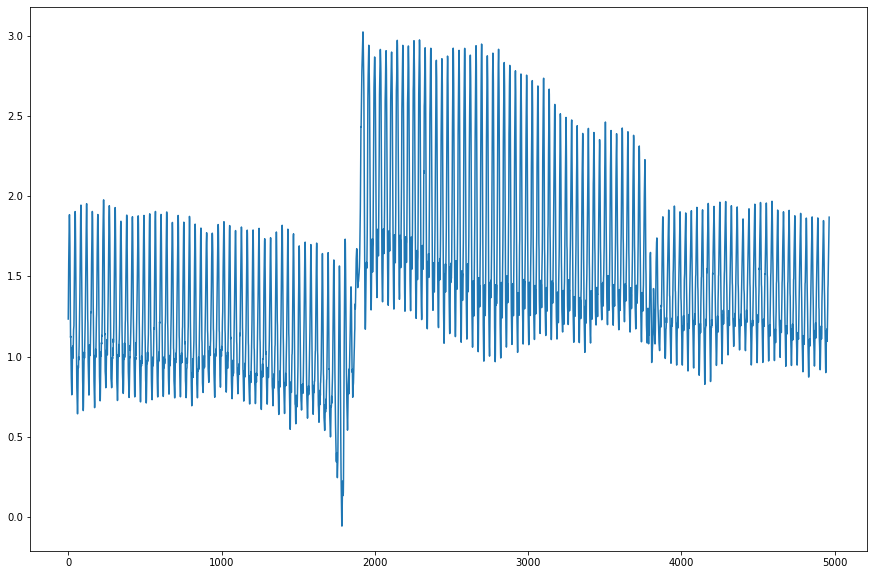

In [7]:
## Plotting the reference series

fig,ax = plt.subplots(figsize=(15,10))
plt.plot(ref_total)

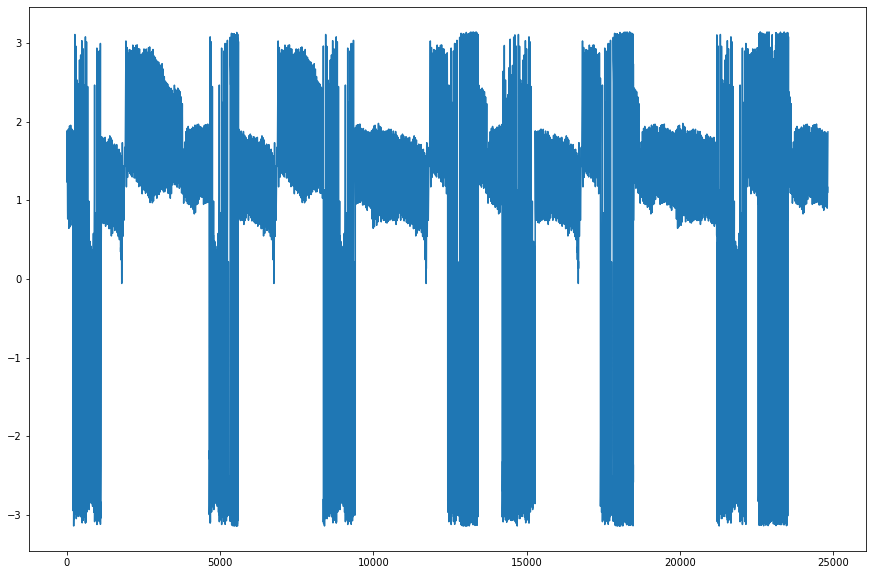

In [8]:
## Plotting the test series

fig,ax = plt.subplots(figsize=(15,10))
plt.plot(curr_test)

In [19]:
def plot_drift_graph(df_plot,sheet_name):

    plt.plot(df_plot['K-S p_value'],label='K-S p_value')
    plt.plot(df_plot['PSI'],label='PSI')
    plt.plot(df_plot['Kullback-Leibler divergence'],label='Kullback-Leibler divergence')
    plt.plot(df_plot['Jensen-Shannon distance'],label='Jensen-Shannon distance')
    plt.plot(df_plot['Wasserstein distance (normed)'],label='Wasserstein distance (normed)')
    plt.xticks(df_plot.index[::100],df_plot['index'][::100],rotation=90)
    plt.yticks(range(15),range(15))
    #plt.axvline(x = list(df_plot[df_plot['index']=='t=10000'].index)[0], color = 'black', label = 'Drift',ls='--')
    plt.xlabel('Time',fontsize=15)
    plt.ylabel('Parameter Value',fontsize=15)
    plt.title(sheet_name,fontsize=15)
    plt.grid()
    plt.legend()

Current Window size is  100


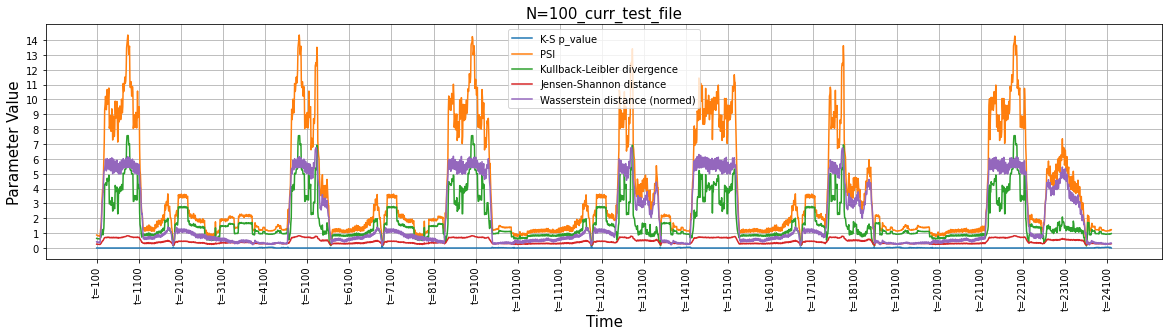

In [20]:
# Driver code to test for data drift

curr_test_file = "Subject_2_11_distributed_drift_2000_1000_50"

N_list = [100]
axes_ind = 1


for N in N_list:
    
    print('Current Window size is ',N)
    
    curr_buff = curr_test[:N]
    chunk_size= 10

    curr_start = N
    curr_end = N+chunk_size

    end_data = 24200
    curr_t = N

    result_pd = pd.DataFrame()
    fun_name = [ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test]
    test_names = [each_test.display_name for each_test in fun_name]
    result_pd['Test'] = test_names

    #curr_ref = ref_total[:N]
    curr_ref = ref_total[:]


    while(curr_end <= end_data ):
        
        curr_res = return_drift(curr_ref, curr_buff)
        result_pd['t=' + str(curr_t)] = curr_res

        ## Importing the new chunk
        curr_start = curr_start + chunk_size
        curr_end = curr_end + chunk_size
        curr_chunk = curr_test[curr_start:curr_end]

        curr_buff = curr_buff[chunk_size:]
        curr_buff = pd.concat([curr_buff,curr_chunk])
        curr_t = curr_t + chunk_size

    result_pd = result_pd.T


    result_pd.columns = result_pd.iloc[0]
    result_pd.drop(result_pd.index[0],inplace=True)
    result_pd.reset_index(drop=False,inplace=True)

    fig,ax = plt.subplots(figsize=(20,25))
    plt.subplot(5,1,axes_ind)
    plot_drift_graph(result_pd,"N=" + str(N) + "_" + 'curr_test_file')

    axes_ind +=1
    
    #result_pd.to_csv('/Users/kiranjyothisheena/Documents/Kiran_Files/CDL_Practicum/Results/Motion_Sense_Exp/' + "N=" + str(N) + "_" + curr_test_file + ".csv")

## Results

In [3]:
fun_name = [ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test]
test_names = [each_test.display_name for each_test in fun_name]

res_path = '/Users/kiranjyothisheena/Documents/Kiran_Files/CDL_Practicum/Results/Motion_Sense_Exp/'


### N =100

Total drift points is  805.0


,Test,TN,FP,FN,TP,Accuracy,Precision,Recall
0,PSI,1476,129,47,758,0.926971,0.854566,0.941615
0,JS,1586,19,107,698,0.947718,0.973501,0.867081
0,KL_div,1509,96,293,512,0.838589,0.842105,0.636025


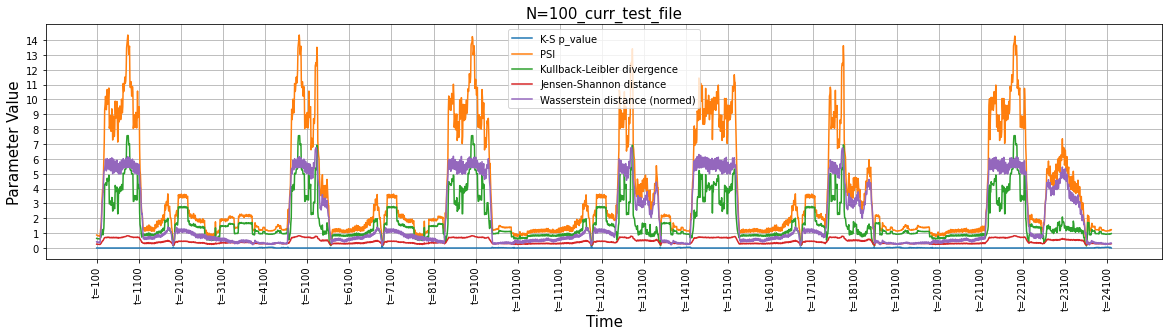

In [22]:

test_file_name = 'N=100_Subject_2_11_distributed_drift_2000_1000_50.csv'
result_pd = pd.read_csv(res_path + test_file_name)

N= 100
chunk_size=10
end_data = 24200

result_pd.columns = result_pd.iloc[0]
result_pd.drop(result_pd.index[0],inplace=True)
result_pd.reset_index(drop=True,inplace=True)
result_pd.rename({"Test":"index"},inplace=True,axis=1)

#fig,ax = plt.subplots(figsize=(20,25))
#plt.subplot(4,1,axes_ind)
#plot_drift_graph(result_pd,"Drift fig")

## Creating a dataframe to plot the results
result_plot = result_pd.copy()
result_plot[['K-S p_value', 'PSI', 'Kullback-Leibler divergence',
       'Jensen-Shannon distance', 'Wasserstein distance (normed)']] = result_plot[['K-S p_value', 'PSI', 'Kullback-Leibler divergence',
       'Jensen-Shannon distance', 'Wasserstein distance (normed)']].astype('float64')
#result_check
fig,ax = plt.subplots(figsize=(20,25))
plt.subplot(5,1,axes_ind)
plot_drift_graph(result_plot,"N=" + str(N) + "_" + 'curr_test_file')

result_pd_2  = result_pd.copy()
for each_test in test_names:
    result_pd_2[each_test] = result_pd_2[each_test].astype('float')

index_col = np.arange(start=N,stop=end_data,step=chunk_size)

indi_column = curr_indi[index_col].reset_index(drop=True)

result_pd_2['Correct_mark'] = indi_column

print('Total drift points is ',sum(indi_column))

PSI_threshold = 3
JS_threshhold = 0.5
KL_Div_threshold = 2

result_pd_2['PSI_drift'] = np.where(result_pd_2['PSI']>PSI_threshold,1,0)
result_pd_2['JS_drift'] = np.where(result_pd_2['Jensen-Shannon distance']>JS_threshhold,1,0)
result_pd_2['KL_drift'] = np.where(result_pd_2['Kullback-Leibler divergence']>KL_Div_threshold,1,0)

tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['PSI_drift'],labels=[0,1]).ravel()
summary_pd = pd.DataFrame({"Test":["PSI"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['JS_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["JS"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['KL_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["KL_div"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])

summary_pd['Accuracy'] = (summary_pd['TP'] + summary_pd['TN'])/summary_pd.sum(axis=1,numeric_only=True)
summary_pd['Precision'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FP'])
summary_pd['Recall'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FN'])

summary_pd

### N = 200

Total drift points is  805.0


,Test,TN,FP,FN,TP,Accuracy,Precision,Recall
0,PSI,1490,105,82,723,0.922083,0.873188,0.898137
0,JS,1567,28,158,647,0.922500,0.958519,0.803727
0,KL_div,1542,53,369,436,0.824167,0.891616,0.541615


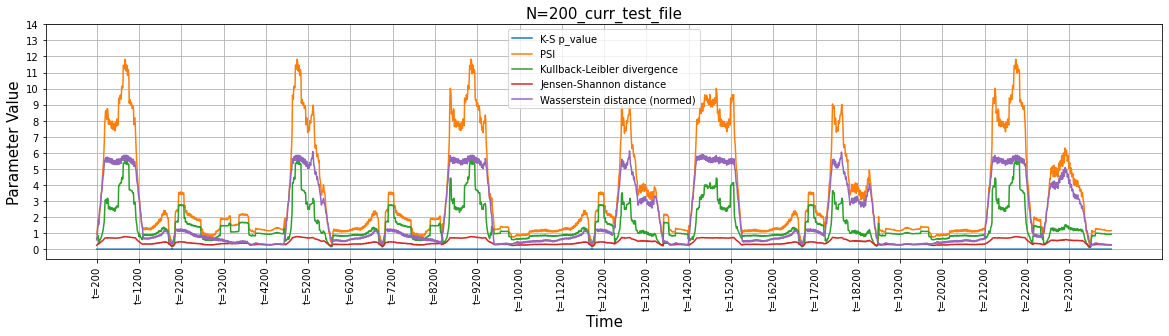

In [52]:
test_file_name = 'N=200_Subject_2_11_distributed_drift_2000_1000_50.csv'
result_pd = pd.read_csv(res_path + test_file_name)

N= 200
chunk_size=10
end_data = 24200

result_pd.columns = result_pd.iloc[0]
result_pd.drop(result_pd.index[0],inplace=True)
result_pd.reset_index(drop=True,inplace=True)
result_pd.rename({"Test":"index"},inplace=True,axis=1)

#fig,ax = plt.subplots(figsize=(20,25))
#plt.subplot(4,1,axes_ind)
#plot_drift_graph(result_pd,"Drift fig")

## Creating a dataframe to plot the results
result_plot = result_pd.copy()
result_plot[['K-S p_value', 'PSI', 'Kullback-Leibler divergence',
       'Jensen-Shannon distance', 'Wasserstein distance (normed)']] = result_plot[['K-S p_value', 'PSI', 'Kullback-Leibler divergence',
       'Jensen-Shannon distance', 'Wasserstein distance (normed)']].astype('float64')
#result_check
fig,ax = plt.subplots(figsize=(20,25))
plt.subplot(5,1,axes_ind)
plot_drift_graph(result_plot,"N=" + str(N) + "_" + 'curr_test_file')

result_pd_2  = result_pd.copy()
for each_test in test_names:
    result_pd_2[each_test] = result_pd_2[each_test].astype('float')

index_col = np.arange(start=N,stop=end_data,step=chunk_size)

indi_column = curr_indi[index_col].reset_index(drop=True)

result_pd_2['Correct_mark'] = indi_column

print('Total drift points is ',sum(indi_column))

PSI_threshold = 3
JS_threshhold = 0.5
KL_Div_threshold = 2

result_pd_2['PSI_drift'] = np.where(result_pd_2['PSI']>PSI_threshold,1,0)
result_pd_2['JS_drift'] = np.where(result_pd_2['Jensen-Shannon distance']>JS_threshhold,1,0)
result_pd_2['KL_drift'] = np.where(result_pd_2['Kullback-Leibler divergence']>KL_Div_threshold,1,0)

tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['PSI_drift'],labels=[0,1]).ravel()
summary_pd = pd.DataFrame({"Test":["PSI"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['JS_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["JS"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['KL_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["KL_div"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])

summary_pd['Accuracy'] = (summary_pd['TP'] + summary_pd['TN'])/summary_pd.sum(axis=1,numeric_only=True)
summary_pd['Precision'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FP'])
summary_pd['Recall'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FN'])

summary_pd

### N = 500

Total drift points is  775.0


,Test,TN,FP,FN,TP,Accuracy,Precision,Recall
0,PSI,1476,119,184,591,0.872152,0.832394,0.762581
0,JS,1521,74,266,509,0.856540,0.873070,0.656774
0,KL_div,1585,10,532,243,0.771308,0.960474,0.313548


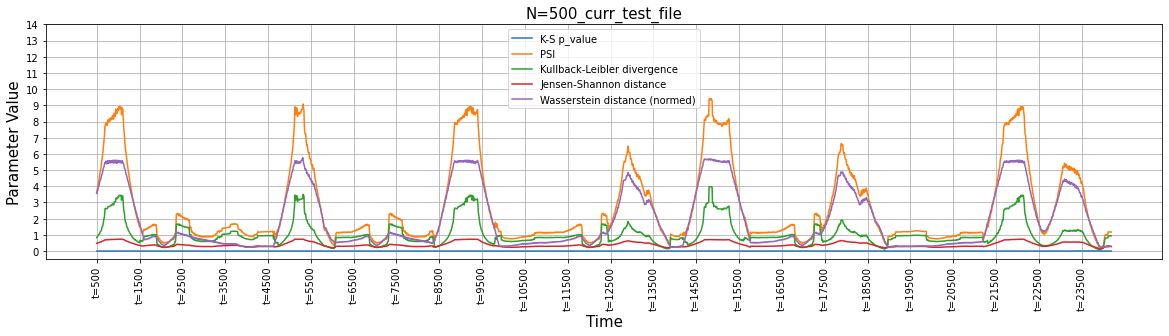

In [53]:
#### OVERALL (N=4000)

test_file_name = 'N=500_Subject_2_11_distributed_drift_2000_1000_50.csv'
result_pd = pd.read_csv(res_path + test_file_name)

N= 500
chunk_size=10
end_data = 24200

result_pd.columns = result_pd.iloc[0]
result_pd.drop(result_pd.index[0],inplace=True)
result_pd.reset_index(drop=True,inplace=True)
result_pd.rename({"Test":"index"},inplace=True,axis=1)

#fig,ax = plt.subplots(figsize=(20,25))
#plt.subplot(4,1,axes_ind)
#plot_drift_graph(result_pd,"Drift fig")

## Creating a dataframe to plot the results
result_plot = result_pd.copy()
result_plot[['K-S p_value', 'PSI', 'Kullback-Leibler divergence',
       'Jensen-Shannon distance', 'Wasserstein distance (normed)']] = result_plot[['K-S p_value', 'PSI', 'Kullback-Leibler divergence',
       'Jensen-Shannon distance', 'Wasserstein distance (normed)']].astype('float64')
#result_check
fig,ax = plt.subplots(figsize=(20,25))
plt.subplot(5,1,axes_ind)
plot_drift_graph(result_plot,"N=" + str(N) + "_" + 'curr_test_file')

result_pd_2  = result_pd.copy()
for each_test in test_names:
    result_pd_2[each_test] = result_pd_2[each_test].astype('float')

index_col = np.arange(start=N,stop=end_data,step=chunk_size)

indi_column = curr_indi[index_col].reset_index(drop=True)

result_pd_2['Correct_mark'] = indi_column

print('Total drift points is ',sum(indi_column))

PSI_threshold = 3
JS_threshhold = 0.5
KL_Div_threshold = 2

result_pd_2['PSI_drift'] = np.where(result_pd_2['PSI']>PSI_threshold,1,0)
result_pd_2['JS_drift'] = np.where(result_pd_2['Jensen-Shannon distance']>J S_threshhold,1,0)
result_pd_2['KL_drift'] = np.where(result_pd_2['Kullback-Leibler divergence']>KL_Div_threshold,1,0)

tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['PSI_drift'],labels=[0,1]).ravel()
summary_pd = pd.DataFrame({"Test":["PSI"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['JS_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["JS"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['KL_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["KL_div"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])

summary_pd['Accuracy'] = (summary_pd['TP'] + summary_pd['TN'])/summary_pd.sum(axis=1,numeric_only=True)
summary_pd['Precision'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FP'])
summary_pd['Recall'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FN'])

summary_pd

### N = 1000

Total drift points is  725.0


,Test,TN,FP,FN,TP,Accuracy,Precision,Recall
0,PSI,1320,275,360,365,0.726293,0.570312,0.503448
0,JS,1415,180,526,199,0.695690,0.525066,0.274483
0,KL_div,1582,13,697,28,0.693966,0.682927,0.038621


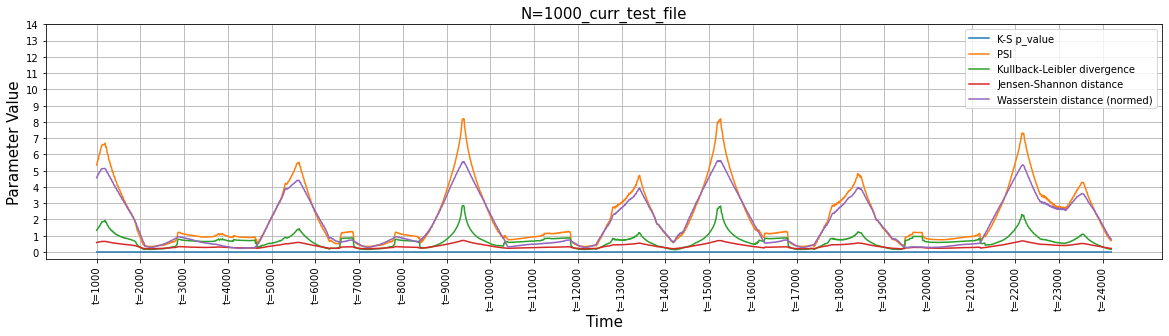

In [54]:


test_file_name = 'N=1000_Subject_2_11_distributed_drift_2000_1000_50.csv'
result_pd = pd.read_csv(res_path + test_file_name)

N= 1000
chunk_size=10
end_data = 24200

result_pd.columns = result_pd.iloc[0]
result_pd.drop(result_pd.index[0],inplace=True)
result_pd.reset_index(drop=True,inplace=True)
result_pd.rename({"Test":"index"},inplace=True,axis=1)

#fig,ax = plt.subplots(figsize=(20,25))
#plt.subplot(4,1,axes_ind)
#plot_drift_graph(result_pd,"Drift fig")

## Creating a dataframe to plot the results
result_plot = result_pd.copy()
result_plot[['K-S p_value', 'PSI', 'Kullback-Leibler divergence',
       'Jensen-Shannon distance', 'Wasserstein distance (normed)']] = result_plot[['K-S p_value', 'PSI', 'Kullback-Leibler divergence',
       'Jensen-Shannon distance', 'Wasserstein distance (normed)']].astype('float64')
#result_check
fig,ax = plt.subplots(figsize=(20,25))
plt.subplot(5,1,axes_ind)
plot_drift_graph(result_plot,"N=" + str(N) + "_" + 'curr_test_file')

result_pd_2  = result_pd.copy()
for each_test in test_names:
    result_pd_2[each_test] = result_pd_2[each_test].astype('float')

index_col = np.arange(start=N,stop=end_data,step=chunk_size)

indi_column = curr_indi[index_col].reset_index(drop=True)

result_pd_2['Correct_mark'] = indi_column

print('Total drift points is ',sum(indi_column))

PSI_threshold = 3
JS_threshhold = 0.5
KL_Div_threshold = 2

result_pd_2['PSI_drift'] = np.where(result_pd_2['PSI']>PSI_threshold,1,0)
result_pd_2['JS_drift'] = np.where(result_pd_2['Jensen-Shannon distance']>JS_threshhold,1,0)
result_pd_2['KL_drift'] = np.where(result_pd_2['Kullback-Leibler divergence']>KL_Div_threshold,1,0)

tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['PSI_drift'],labels=[0,1]).ravel()
summary_pd = pd.DataFrame({"Test":["PSI"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['JS_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["JS"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['KL_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["KL_div"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])

summary_pd['Accuracy'] = (summary_pd['TP'] + summary_pd['TN'])/summary_pd.sum(axis=1,numeric_only=True)
summary_pd['Precision'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FP'])
summary_pd['Recall'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FN'])

summary_pd

### N= 2000

Total drift points is  712.0


,Test,TN,FP,FN,TP,Accuracy,Precision,Recall
0,PSI,1410,98,620,92,0.676577,0.484211,0.129213
0,JS,1508,0,669,43,0.698649,1.000000,0.060393
0,KL_div,1508,0,712,0,0.679279,NaN,0.000000


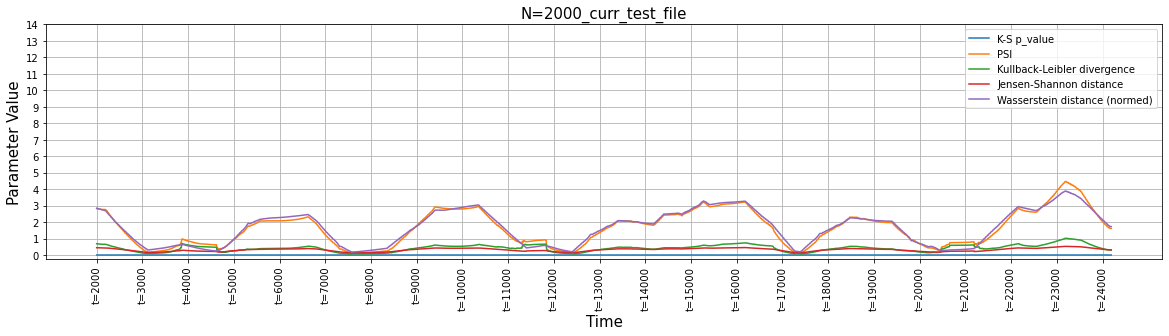

In [55]:

test_file_name = 'N=2000_Subject_2_11_distributed_drift_2000_1000_50.csv'
result_pd = pd.read_csv(res_path + test_file_name)

N= 2000
chunk_size=10
end_data = 24200

result_pd.columns = result_pd.iloc[0]
result_pd.drop(result_pd.index[0],inplace=True)
result_pd.reset_index(drop=True,inplace=True)
result_pd.rename({"Test":"index"},inplace=True,axis=1)

#fig,ax = plt.subplots(figsize=(20,25))
#plt.subplot(4,1,axes_ind)
#plot_drift_graph(result_pd,"Drift fig")

## Creating a dataframe to plot the results
result_plot = result_pd.copy()
result_plot[['K-S p_value', 'PSI', 'Kullback-Leibler divergence',
       'Jensen-Shannon distance', 'Wasserstein distance (normed)']] = result_plot[['K-S p_value', 'PSI', 'Kullback-Leibler divergence',
       'Jensen-Shannon distance', 'Wasserstein distance (normed)']].astype('float64')
#result_check
fig,ax = plt.subplots(figsize=(20,25))
plt.subplot(5,1,axes_ind)
plot_drift_graph(result_plot,"N=" + str(N) + "_" + 'curr_test_file')

result_pd_2  = result_pd.copy()
for each_test in test_names:
    result_pd_2[each_test] = result_pd_2[each_test].astype('float')

index_col = np.arange(start=N,stop=end_data,step=chunk_size)

indi_column = curr_indi[index_col].reset_index(drop=True)

result_pd_2['Correct_mark'] = indi_column

print('Total drift points is ',sum(indi_column))

PSI_threshold = 3
JS_threshhold = 0.5
KL_Div_threshold = 2

result_pd_2['PSI_drift'] = np.where(result_pd_2['PSI']>PSI_threshold,1,0)
result_pd_2['JS_drift'] = np.where(result_pd_2['Jensen-Shannon distance']>JS_threshhold,1,0)
result_pd_2['KL_drift'] = np.where(result_pd_2['Kullback-Leibler divergence']>KL_Div_threshold,1,0)

tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['PSI_drift'],labels=[0,1]).ravel()
summary_pd = pd.DataFrame({"Test":["PSI"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['JS_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["JS"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])
tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['KL_drift'],labels=[0,1]).ravel()
summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["KL_div"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])

summary_pd['Accuracy'] = (summary_pd['TP'] + summary_pd['TN'])/summary_pd.sum(axis=1,numeric_only=True)
summary_pd['Precision'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FP'])
summary_pd['Recall'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FN'])

summary_pd

In this particular case, a window size of 100 has the highest accuracy.

## Summary

The optimum window size for different cases are found to be different. For the first case, the opimum window size is found to be 4000 and in the second case it is 100. Therefore, before conducting data drift it is important to determine a good window size to conduct the analysis.